## RECOMMENDER SYSTEMS WORKSHOP by Bhavik Gandhi

A recommender system or a recommendation system (sometimes replacing "system" with a synonym such as platform or engine) is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.

Recommender systems have become increasingly popular in recent years, and are utilized in a variety of areas including movies, music, news, books, research articles, search queries, social tags, and products in general. There are also recommender systems for experts, collaborators, jokes, restaurants, garments, financial services, life insurance, romantic partners (online dating), and Twitter pages.

A lot of companies rely heavily on their recommendation systems. Amazon gets a ton of sales from its recommendation system. Netflix has gained a ton of popularity for its recommendation system. In fact back in 2006 they even offered 1 million in prize money to anyone who would better their recommendation algorithm by 10%. (And the prize was claimed in 2009). Youtube does a great job at recommending videos, Spotify at recommending music and Facebook recommending pages you'd like to follow.
In short we are well surrounded by Recommender Systems

Let's take a look at how these things work.

There are basic recommenders like IMDB Top 250 which is simply put recommend the most popular items and people would like them
It does not personalize for people's unique tastes and interests. Let's build a basic one first.

In [1]:
# Import Pandas
import pandas as pd

metadata = pd.read_csv('tmdb_s/movies_metadata.csv')

# Print the first three rows
metadata.head(3)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [2]:
# Calculate C
C = metadata['vote_average'].mean()
print(C)

5.618207215133889


In [3]:
# Calculate the minimum number of votes required to be in the chart, m
m = metadata['vote_count'].quantile(0.90)
print(m)

160.0


In [4]:
# Filter out all qualified movies into a new DataFrame
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
print(q_movies.shape)
print(metadata.shape)

(4555, 24)
(45466, 24)


In [5]:
# Function that computes the weighted rating of each movie
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [6]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [7]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


However we do want to personalize our recommendations. So let's look at a slightly more complex system

We have a good amount of content about the movie. So let's look at how we can exploit this content

What we will try to build now is called a Content Based Recommendation Engine

The way this works is we try and understand in terms of the available content/ attributes about an item, which other items is it most similar to. For instance if item A is similar to item B, C and E but not so similar to item D. Then for a user who we know likes item A, we would recommend B, C and E but not D (even though D might be extremely popular)

In [8]:
## Content based
#Print plot overviews of the first 5 movies.
print(metadata['overview'].head())
metadata2 = metadata

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object


In [9]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
metadata = metadata2[0:10000]
metadata['overview'] = metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(10000, 32350)

In [10]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [11]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(metadata.index, index=metadata['title']).drop_duplicates()

In [12]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [13]:
get_recommendations('The Godfather')

1178     The Godfather: Part II
1914    The Godfather: Part III
8653               Violent City
6711                   Mobsters
6977            Queen of Hearts
8191                     Eulogy
2891             American Movie
4324                       Made
4464            Family Business
5689        The Young Americans
Name: title, dtype: object

In [14]:
get_recommendations('The Empire Strikes Back')

256                                        Star Wars
1167                              Return of the Jedi
6893                                     The Witches
2514       Star Wars: Episode I - The Phantom Menace
855                                        First Kid
1231                                  Cool Hand Luke
3602                                     Coming Home
5244    Star Wars: Episode II - Attack of the Clones
249                       Interview with the Vampire
4146                                       Cleopatra
Name: title, dtype: object

In [15]:
# Load keywords and credits
credits = pd.read_csv('tmdb_s/credits.csv')
keywords = pd.read_csv('tmdb_s/keywords.csv')

# Remove rows with bad IDs.
#metadata = metadata.drop([19730, 29503, 35587])
#metadata = metadata.drop([19730])

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [16]:
# Print the first two movies of your newly merged metadata
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [17]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

In [2]:
# Import Numpy 
import numpy as np

In [19]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [20]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [21]:
# Define new director, cast, genres and keywords features that are in a suitable form.
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)

In [22]:
# Print the new features of the first 3 films
metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [23]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [24]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)

In [25]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [26]:
# Create a new soup feature
metadata['soup'] = metadata.apply(create_soup, axis=1)

In [27]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

In [28]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [29]:
# Reset index of your main DataFrame and construct reverse mapping as before
metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['title'])

In [30]:
get_recommendations('The Empire Strikes Back', cosine_sim2)

256                               Star Wars
1180                     Return of the Jedi
685                                    Solo
1338        Star Trek II: The Wrath of Khan
7946                   The Last Starfighter
8804                            Futureworld
2174                     Six-String Samurai
1169                Raiders of the Lost Ark
1259     Indiana Jones and the Last Crusade
1339    Star Trek III: The Search for Spock
Name: title, dtype: object

In [31]:
get_recommendations('The Godfather', cosine_sim2)

1926           The Godfather: Part III
1191            The Godfather: Part II
7965    The Night of the Following Day
7736                          Mitchell
1178                    Apocalypse Now
1640                  Ill Gotten Gains
3475        Jails, Hospitals & Hip-Hop
4000                  Gardens of Stone
5285                       The Gambler
5                                 Heat
Name: title, dtype: object

In [1]:
import pandas as pd
#Recommend for a user using item similarity rather than for an item
ratings = pd.read_csv('tmdb_s/ratings.csv')

# Print the first three rows
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523


In [33]:
print(ratings['rating'].min())
print(ratings['rating'].max())
print(ratings['rating'].mean())

0.5
5.0
3.5280903543608817


In [2]:
ratings = ratings.loc[ratings['movieId'] < 10000]
from sklearn.model_selection import train_test_split
train_ratings, test_ratings = train_test_split(ratings, test_size=0.3, random_state=42)

In [3]:
print(ratings.shape)
print(train_ratings.shape)
print(test_ratings.shape)

(21095738, 4)
(14767016, 4)
(6328722, 4)


In [200]:
# Function that takes in user id as input and outputs most recommended movies based on content
def get_content_recommendations(userId, ratings=ratings, cosine_sim=cosine_sim, top=10001):
    # Get the movies rated by the user
    user_ratings = ratings.copy().loc[ratings['userId'] == userId]
    user_mean = user_ratings['rating'].mean()
    aggregated_sim_scores = np.zeros(10000)
    
    for i, user_rating in user_ratings.iterrows():
        # Get the pairwsie similarity scores of all movies with that movie
        user_fb = user_rating['rating']#-user_mean+0.2
        weighted_sim_scores = np.array(cosine_sim[int(user_rating['movieId'])],dtype=float)*user_fb
        aggregated_sim_scores = np.add(aggregated_sim_scores,weighted_sim_scores)
    
    aggregated_sim_scores = aggregated_sim_scores/len(user_ratings)
    sim_scores = aggregated_sim_scores.tolist()
    sim_scores = enumerate(sim_scores)
        
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    #remove movies rated in training set
    sim_scores = [item for item in sim_scores if item[0] not in user_ratings['movieId']]
    
    # Get the scores of the top most similar movies
    if(top<len(sim_scores)):
        sim_scores = sim_scores[1:top]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top most similar movies
    return tuple(zip(movie_indices,metadata['title'].iloc[movie_indices],[i[1] for i in sim_scores]))

In [201]:
print(get_content_recommendations(1, train_ratings))

((2918, 'Drugstore Cowboy', 0.7123964198748169), (5577, 'Take Care of My Cat', 0.6796290913876486), (1246, 'Young Frankenstein', 0.6678404767887777), (1221, 'The Day the Earth Stood Still', 0.6574823706814606), (4878, 'Spacehunter: Adventures in the Forbidden Zone', 0.6457798183374216), (2959, 'Holiday Inn', 0.5432949540415903), (1968, 'The Purple Rose of Cairo', 0.5142341839355478), (8031, 'The Snake Pit', 0.17244258810796534), (6685, 'Common Wealth', 0.17124527095434372), (1840, 'Going My Way', 0.1711315568360137), (110, 'Rumble in the Bronx', 0.14876324465303487), (2991, 'McCabe & Mrs. Miller', 0.146660706134565), (890, 'The Gay Divorcee', 0.14389665501840598), (9683, 'Monday Morning', 0.14212567482558788), (2088, 'I Confess', 0.14034711086075702), (7774, 'City of Joy', 0.1402553857883871), (7794, 'The Adventures of Sherlock Holmes', 0.1345565202759132), (6683, 'By the Sword', 0.13165566630756828), (2917, 'Re-Animator', 0.13135079998639163), (7875, 'Two Brothers', 0.1275256482157990

In [157]:
print(test_ratings.copy().loc[(ratings['userId'] == 1) & (ratings['movieId'] == 1840)])

Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


In [2]:
#Using Word2Vec on Overview and combine

In [14]:
#Evaluate Rec Sys
from math import log

def dcg_at_k(scores):
    assert scores
    return scores[0] + sum(sc / log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores)+1)))

def ndcg_at_k(predicted_scores, user_scores):
    assert len(predicted_scores) == len(user_scores)
    idcg = dcg_at_k(sorted(user_scores, reverse=True))
    return (dcg_at_k(predicted_scores) / idcg) if idcg > 0.0 else 0.0

Moving on, the next type of recommender system is also called the User based Recommender System.

This is more popularly known as Collaborative Filtering and is extremely popular.

By identifying people who have liked similar movies we identify which users are similar to each other and then recommend movies one has liked that the other hasn't seen yet. For instance if user x liked movies D, G, H, K and M and user y liked movies D, G, H and L, we would believe that x and y are similar in their tastes and hence if x liked K and M, we can recommend it to y and if y liked L, we can recommend it to x.

Since we are collaborating multiple users data to filter the items shown to another user, this is called Collaborative Filtering

Amazon's "People who viewed also viewed" and "People who bought also bought" are derivatives of this technique.

In [8]:
dataset={
 'Lisa Rose': {
 'Lady in the Water': 2.5,
 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0,
 'Superman Returns': 3.5,
 'You, Me and Dupree': 2.5,
 'The Night Listener': 3.0},

 'Gene Seymour': {'Lady in the Water': 3.0,
 'Snakes on a Plane': 3.5,
 'Just My Luck': 1.5,
 'Superman Returns': 5.0,
 'The Night Listener': 3.0,
 'You, Me and Dupree': 3.5},
 
 'Michael Phillips': {'Lady in the Water': 2.5,
 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5,
 'The Night Listener': 4.0},

'Claudia Puig': {'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0,
 'The Night Listener': 4.5,
 'Superman Returns': 4.0,
 'You, Me and Dupree': 2.5},
 
 'Mick LaSalle': {'Lady in the Water': 3.0,
 'Snakes on a Plane': 4.0,
 'Just My Luck': 2.0,
 'Superman Returns': 3.0,
 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0},
 
 'Jack Matthews': {'Lady in the Water': 3.0,
 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0,
 'Superman Returns': 5.0,
 'You, Me and Dupree': 3.5},
 
 'Toby': {'Snakes on a Plane':4.5,
 'You, Me and Dupree':1.0,
 'Superman Returns':4.0}}

In [9]:
from math import sqrt
 
def similarity_score(person1,person2):

    # Returns ratio Euclidean distance score of person1 and person2 
 
    both_viewed = {} # To get both rated items by person1 and person2
 
    for item in dataset[person1]:
        if item in dataset[person2]:
            both_viewed[item] = 1
 
        # Conditions to check they both have an common rating items	
        if len(both_viewed) == 0:
            return 0
 
        # Finding Euclidean distance 
        sum_of_euclidean_distance = []
 
        for item in dataset[person1]:
            if item in dataset[person2]:
                sum_of_euclidean_distance.append(pow(dataset[person1][item] - dataset[person2][item],2))
        sum_of_euclidean_distance = sum(sum_of_euclidean_distance)
 
        return 1/(1+sqrt(sum_of_euclidean_distance))

def pearson_correlation(person1,person2):
 
    # To get both rated items
    both_rated = {}
    for item in dataset[person1]:
        if item in dataset[person2]:
            both_rated[item] = 1
 
    number_of_ratings = len(both_rated)

    # Checking for number of ratings in common
    if number_of_ratings == 0:
        return 0
 
    # Add up all the preferences of each user
    person1_preferences_sum = sum([dataset[person1][item] for item in both_rated])
    person2_preferences_sum = sum([dataset[person2][item] for item in both_rated])
 
    # Sum up the squares of preferences of each user
    person1_square_preferences_sum = sum([pow(dataset[person1][item],2) for item in both_rated])
    person2_square_preferences_sum = sum([pow(dataset[person2][item],2) for item in both_rated])
 
    # Sum up the product value of both preferences for each item
    product_sum_of_both_users = sum([dataset[person1][item] * dataset[person2][item] for item in both_rated])
 
    # Calculate the pearson score
    numerator_value = product_sum_of_both_users - (person1_preferences_sum*person2_preferences_sum/number_of_ratings)
    denominator_value = sqrt((person1_square_preferences_sum - pow(person1_preferences_sum,2)/number_of_ratings) * (person2_square_preferences_sum -pow(person2_preferences_sum,2)/number_of_ratings))
    if denominator_value == 0:
        return 0
    else:
        r = numerator_value/denominator_value
        return r
    
def user_recommendations(person):

    # Gets recommendations for a person by using a weighted average of every other user's rankings
    totals = {}
    simSums = {}
    rankings_list =[]
    for other in dataset:
        # don't compare me to myself
        if other == person:
            continue
        sim = pearson_correlation(person,other)

        # ignore scores of zero or lower
        if sim <=0: 
            continue
        for item in dataset[other]:

            # only score movies i haven't seen yet
            if item not in dataset[person] or dataset[person][item] == 0:

                # Similarity * score
                totals.setdefault(item,0)
                totals[item] += dataset[other][item]* sim
                # sum of similarities
                simSums.setdefault(item,0)
                simSums[item]+= sim

        # Create the normalized list

    rankings = [(total/simSums[item],item) for item,total in totals.items()]
    rankings.sort()
    rankings.reverse()
    # returns the recommended items
    recommendations_list = [recommend_item for score,recommend_item in rankings]
    return recommendations_list

In [10]:
print(user_recommendations('Toby'))

['The Night Listener', 'Lady in the Water', 'Just My Luck']


In [5]:
from math import isnan
import copy
train_ratings = train_ratings.loc[train_ratings['userId'] < 1000]
ct = pd.crosstab(train_ratings["movieId"],train_ratings["userId"],values=train_ratings.rating,aggfunc=np.mean, margins=False)
ct_map = ct.to_dict()
ratings_dict = copy.deepcopy(ct_map)
for k,v in ct_map.items():
    for k1,v1 in v.items():
        if np.isnan(v1):
            ratings_dict[k].pop(k1)

In [7]:
dataset = ratings_dict
print(user_recommendations(1))

[8749, 8724, 8125, 7761, 7132, 7073, 7068, 7064, 7043, 6864, 6832, 6684, 6291, 6283, 6133, 6062, 5288, 5105, 5034, 4872, 4422, 4325, 4048, 4005, 3801, 3795, 3794, 3596, 3550, 3470, 3374, 3350, 3329, 3281, 3192, 3134, 3035, 3030, 2940, 2931, 2870, 2443, 2306, 2203, 2159, 1858, 1332, 1306, 1284, 1232, 1218, 1189, 1131, 965, 570, 461, 190, 2554, 2859, 1077, 1468, 2495, 6791, 3655, 1286, 390, 306, 1788, 2843, 3728, 951, 905, 927, 4914, 1340, 940, 5319, 858, 1228, 2696, 5147, 2357, 3037, 2070, 1959, 3083, 1251, 2863, 3272, 50, 903, 272, 2924, 5171, 1949, 8973, 8831, 8633, 8520, 8253, 7925, 7789, 7649, 7303, 7223, 7136, 7042, 7037, 6975, 6828, 6592, 6357, 6093, 6065, 5712, 5644, 5489, 5404, 5353, 5061, 5021, 5012, 4965, 4432, 4405, 4293, 4220, 4103, 4041, 3879, 3708, 3621, 3529, 3429, 3266, 3038, 2897, 2800, 2557, 2500, 2387, 1572, 781, 199, 154, 86, 76, 6993, 1719, 3959, 1950, 953, 2948, 1104, 2501, 2841, 2622, 1299, 1252, 1234, 7982, 5574, 8157, 904, 2731, 296, 1248, 6986, 4190, 8154, 800,

In [12]:
%matplotlib inline

Estimated number of clusters: 3
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.883
Silhouette Coefficient: 0.626


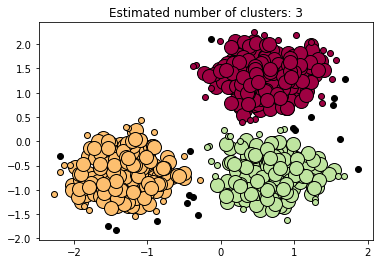

In [13]:
#Cluster users and items for user based
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [9]:
#Try Hybrid Content + Collaborative

# Takeaways
We now covered the most popular recommender systems. While we've made a solid start, there are a ton of interesting challenges and techniques that are being used in Recommender Systems. I would advise you to look at

1. NMF (Non-negative Matrix Factorizations)
2. HMM (Hidden Markov Models)
3. LSTM (Long short term memory models)

# Thank you!
Feel free to follow me on LinkedIn. (https://www.linkedin.com/in/probablybhavik/) 